#### 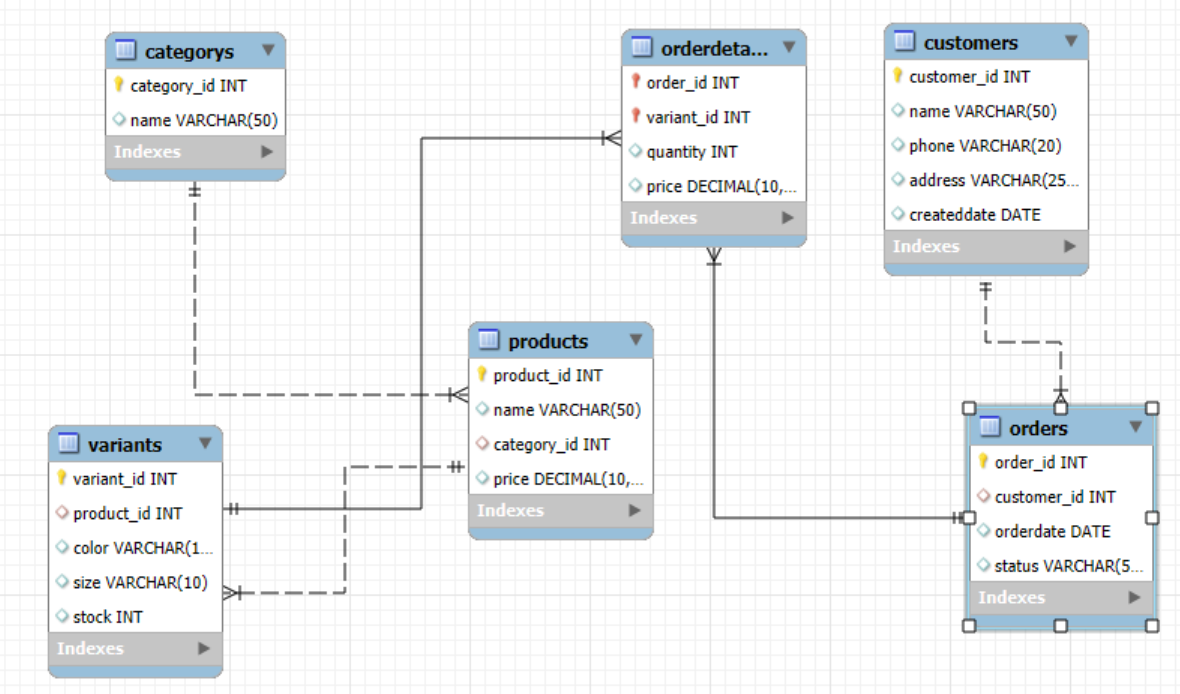

In [ ]:
!pip install mysql-connector-python

In [ ]:
import mysql.connector

connection = mysql.connector.connect(
    host="127.0.0.1",
    user="root",
    password="    ",
    database="banhangquanao")
cursor = connection.cursor()

In [ ]:
cursor.execute("""
create table if not exists Categorys(
    category_id INT PRIMARY KEY,
    name VARCHAR(50)
) ENGINE=InnoDB;
""")
cursor.execute("""
create table if not exists Products(
    product_id INT PRIMARY KEY,
    name VARCHAR(50),
    category_id INT,
    price DECIMAL(10,2),
    FOREIGN KEY(category_id) REFERENCES Categorys(category_id)
) ENGINE=InnoDB;
""")
cursor.execute("""
create table if not exists Variants(
    variant_id INT PRIMARY KEY,
    product_id INT,
    color VARCHAR(10),
    size VARCHAR(10),
    stock INT,
    FOREIGN KEY(product_id) REFERENCES Products(product_id)
) ENGINE=InnoDB;
""")
cursor.execute("""
create table if not exists Customers(
    customer_id INT PRIMARY KEY,
    name VARCHAR(50),
    phone VARCHAR(20),
    address VARCHAR(255),
    createddate DATE
) ENGINE=InnoDB;
""")
cursor.execute("""
create table if not exists Orders(
    order_id INT PRIMARY KEY,
    customer_id INT,
    orderdate DATE,
    status VARCHAR(50),
    FOREIGN KEY(customer_id) REFERENCES Customers(customer_id)
) ENGINE=InnoDB;
""")
cursor.execute("""
create table if not exists OrderDetails(
    order_id INT,
    variant_id INT,
    quantity INT,
    price DECIMAL(10,2),
    PRIMARY KEY(order_id, variant_id),
    FOREIGN KEY(order_id) REFERENCES Orders(order_id),
    FOREIGN KEY(variant_id) REFERENCES Variants(variant_id)
) ENGINE=InnoDB;
""")
connection.commit()

In [ ]:
import pandas as pd
cursor.execute("""
INSERT IGNORE INTO Categorys VALUES
    (1, 'Áo'),
    (2, 'Quần'),
    (3, 'Váy'),
    (4, 'Phụ kiện')
;
""")
connection.commit()

In [ ]:
cursor.execute("""
INSERT INTO Products VALUES
    (101, 'Áo sơ mi nam', 1, 300000),
    (102, 'Quần jeans', 2, 500000),
    (103, 'Váy xòe', 3, 450000)
;""")
connection.commit()

In [ ]:
cursor.execute("""
INSERT INTO Variants VALUES
    (1, 101, 'Trắng', 'M', 20),
    (2, 101, 'Trắng', 'L', 15),
    (3, 102, 'Xanh', 'M', 10),
    (4, 103, 'Đỏ', 'S', 5)
;""")
connection.commit()

In [ ]:
cursor.execute("""
INSERT INTO Customers VALUES
    (1, 'Trần An', '0909123456', 'Hà Nội', '2024-01-10'),
    (2, 'Lê Bình', '0909223456', 'TP.HCM', '2024-02-05')
;""")
connection.commit()

In [ ]:
cursor.execute("""
INSERT INTO Orders VALUES
    (1, 1, '2024-03-01', 'Đã giao'),
    (2, 2, '2024-03-02', 'Đã đặt')
;""")
connection.commit()

In [ ]:
cursor.execute("""
INSERT INTO OrderDetails VALUES
    (1, 1, 2,300000),
    (1, 3, 1,500000),
    (2, 4, 1,450000)
;""")
connection.commit()

In [ ]:
# Liệt kê tất cả các đơn hàng,
# kèm theo tên khách hàng và tổng tiền của mỗi đơn hàng
# SUM(COALESCE(od.quantity, 0) * COALESCE(od.price, 0)) AS Totalod
query="""
SELECT o.order_id, c.name, SUM(od.quantity*od.price) AS TotalAmount
FROM Orders o
JOIN Customers c ON o.customer_id = c.customer_id
JOIN OrderDetails od ON o.order_id=od.order_id
GROUP BY o.order_id, c.name
;"""
connection.commit()
data=pd.read_sql_query(query,connection)
data

In [ ]:
# Liệt kê các sản phẩm có tồn kho dưới 10
query="""
SELECT v.variant_id,p.name, v.color, v.size, v.stock
FROM Variants v
JOIN Products p ON v.product_id= p.product_id
WHERE 1=1
AND v.stock<10
;"""
connection.commit()
data=pd.read_sql_query(query,connection)
data

In [ ]:
#Tính tổng doanh thu theo từng ngày đặt hàng
query="""
SELECT o.orderdate,SUM(od.quantity * od.price) AS DailyRevenue
FROM Orders o
JOIN OrderDetails od ON o.order_id= od.order_id
GROUP BY o.orderdate
;"""
connection.commit()
data=pd.read_sql_query(query,connection)
data

In [ ]:
# Liệt kê các khách hàng đã từng có đơn hàng
query="""
SELECT DISTINCT c.name
FROM Customers c
JOIN Orders o ON c.customer_id= o.customer_id
;"""
connection.commit()
data=pd.read_sql_query(query,connection)
data

In [ ]:
# Liệt kê sản phẩm bán chạy nhất (theo tổng số lượng bán)
query="""
SELECT p.name, sum(od.quantity) AS Totalsold
FROM Orderdetails od
JOIN Variants v ON v.variant_id= od.variant_id
JOIN Products p ON p.product_id = v.product_id
GROUP BY p.name
ORDER BY Totalsold DESC
LIMIT 1
;"""
connection.commit()
data=pd.read_sql_query(query,connection)
data

In [ ]:
# Tính tổng doanh thu theo từng loại danh mục sản phẩm
query="""
SELECT cat.name, SUM(od.quantity * od.price)  AS CatRevenue
FROM OrderDetails od
JOIN Variants v ON od.variant_id=  v.variant_id
JOIN Products p ON v.product_id = p.product_id
JOIN Categorys cat ON p.category_id = cat.category_id
GROUP BY cat.name
;"""
connection.commit()
data=pd.read_sql_query(query,connection)
data

In [ ]:
# Hiển thị chi tiết của một đơn hàng cụ thể (gồm tên sản phẩm, màu, size, số lượng, đơn giá, tổng dòng)
query="""
SELECT o.order_id, p.name, v.color, v.size, od.quantity, od.price, (od.quantity * od.price) AS Totalline
FROM Orders o
JOIN OrderDetails od ON o.order_id = od.order_id
JOIN Variants v ON od.variant_id = v.variant_id
JOIN Products p ON v.product_id = p.product_id
WHERE 1=1
AND o.order_id=1
;"""
connection.commit()
data=pd.read_sql_query(query,connection)
data

In [ ]:
# Liệt kê các khách hàng chưa từng thực hiện đơn hàng nào
query="""
SELECT c.name
FROM Customers c
LEFT JOIN Orders o ON c.customer_id = o.customer_id
WHERE o.order_id IS NULL
;"""
connection.commit()
data=pd.read_sql_query(query,connection)
data

In [ ]:
# Thống kê số lượng khách hàng mới theo từng tháng
query="""
SELECT EXTRACT(YEAR FROM createddate) AS Year,
       EXTRACT(MONTH FROM createddate) AS Month,
       COUNT(*) AS Newcustomers
FROM Customers
GROUP BY EXTRACT(YEAR FROM createddate), EXTRACT(MONTH FROM createddate)
ORDER BY Year, Month
;"""
connection.commit()
data=pd.read_sql_query(query,connection)
data

In [ ]:
# Thống kê số đơn hàng theo từng trạng thái (đã giao, đã đặt, đã huỷ)
query="""
SELECT status, COUNT(*) AS CountOrders
FROM Orders
GROUP BY status
;"""
connection.commit()
data=pd.read_sql_query(query,connection)
data

In [ ]:
# Tính tồn kho trung bình theo từng danh mục sản phẩm
query="""
SELECT cat.name, AVG(v.stock) AS AvgStock
FROM Variants v
JOIN Products p ON v.product_id = p.product_id
JOIN Categorys cat ON p.category_id = cat.category_id
GROUP BY cat.name
;"""
connection.commit()
data=pd.read_sql_query(query,connection)
data